### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Download data
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     46      0 --:--:-- --:--:-- --:--:--    46
100   299  100   299    0     0    238      0  0:00:01  0:00:01 --:--:--     0
100  119M  100  119M    0     0  24.0M      0  0:00:04  0:00:04 --:--:-- 41.8M
Train_rev1.csv


In [2]:
data = pd.read_csv("../data/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [4]:
data.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [5]:
# Types of columns
data.dtypes

Id                     int64
Title                 object
FullDescription       object
LocationRaw           object
LocationNormalized    object
ContractType          object
ContractTime          object
Company               object
Category              object
SalaryRaw             object
SalaryNormalized       int64
SourceName            object
dtype: object

In [6]:
# Number of unique values in each categorical column
# List of categorical columns
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
for c in categorical_columns:
    print(c, data[c].nunique())

Title 135435


FullDescription 242138
LocationRaw 20986
LocationNormalized 2732
ContractType 2
ContractTime 2
Company 20812
Category 29
SalaryRaw 97286
SourceName 167


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

(array([  447.,   267.,   521.,   617.,  5549., 13073., 19631., 22836.,
        33116., 35581., 36991., 28050., 16408., 17527.,  7096.,  5505.,
         1309.,   135.,    64.,    45.]),
 array([ 8.51739311,  8.70182705,  8.88626194,  9.07069588,  9.25512981,
         9.43956375,  9.62399864,  9.80843258,  9.99286652, 10.17730141,
        10.36173534, 10.54616928, 10.73060417, 10.91503811, 11.09947205,
        11.28390694, 11.46834087, 11.65277481, 11.83720875, 12.02164364,
        12.20607758]),
 <BarContainer object of 20 artists>)

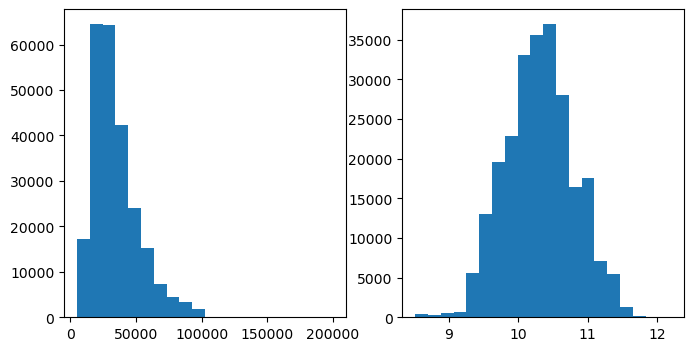

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)

Our task is to predict one number, Log1pSalary.

To do so, our model can access a number of features:

Free text: Title and  FullDescription
Categorical: Category, Company, LocationNormalized, ContractType, and ContractTime.

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

## Preprocessing text data

Applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

Lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a space-separated string of tokens for performance reasons.

It's okay to use `nltk` tokenizers.

In [5]:
print("Raw data:")
print(data["FullDescription"][2::100000])

Raw data:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [6]:
# How many missing values are there in 'FullDescription' and 'Title' columns?
print("Number of missing values in 'FullDescription':", data["FullDescription"].isnull().sum())
print("Number of missing values in 'Title':", data["Title"].isnull().sum())

Number of missing values in 'FullDescription': 0
Number of missing values in 'Title': 1


In [7]:
# Drop rows with missing values in 'Title' column
data = data[~data["Title"].isnull()]

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = WordPunctTokenizer().tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

data['Title'] = data['Title'].apply(preprocess_text)
data['FullDescription'] = data['FullDescription'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100003    strategy education approached secondary school...
200003    working within financial sector , client servi...
Name: FullDescription, dtype: object


In [13]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total

for text in data["Title"]:
    token_counts.update(text.split())

for text in data["FullDescription"]:
    token_counts.update(text.split())

In [14]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 195563
('.', 2523211)
(',', 2318603)
('****', 681862)
('/', 554003)
('experience', 432301)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)


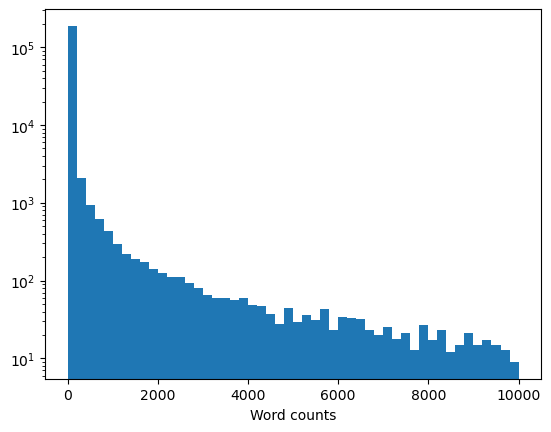

In [15]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [16]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total

for text in data["Title"]:
    token_counts.update(text.split())

for text in data["FullDescription"]:
    token_counts.update(text.split())

print("Total number of tokens:", len(token_counts))

Total number of tokens: 195563


Get a list of all tokens that occur at least 10 times.

In [17]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset. sorted by frequency
tokens = [t for t, c in token_counts.items() if c >= min_count]
# Sort tokens by their number of occurences
tokens = sorted(tokens, key=lambda x: -token_counts[x])
print("Tokens:", len(tokens))

Tokens: 30665


In [18]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

Build an inverse token index: a dictionary from token(string) to it's index in tokens (int)

In [19]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [20]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

let's use the vocabulary we've built to map text lines into neural network-digestible matrices.

Each word in a sequence is mapped to an index (integer) using a vocabulary (`token_to_id`). If the word is not present in the vocabulary, it’s mapped to a special "unknown" token `UNK_IX`, and padding is done using a special "padding" token `PAD_IX`.

In [21]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    # ^ calculates the maximum length of sequences but doesn’t allow it to exceed the provided max_len, if any. 
    # If max_len is not provided, it’s initialized as infinity, and the actual max_len used is the maximum sequence length in the provided sequences.
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    # ^ creates a matrix of shape (len(sequences), max_len) filled with PAD_IX values

    # Populate matrix with sequences
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [22]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering system analyst
year 3 teacher northampton
senior associate employment solution

Matrix:
[[ 108   43  196    1]
 [  56  316  195 2211]
 [  72  706   81  119]]


Now let's encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. 

TODO: implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [23]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
#  Replacing Lesser Known Companies with "Other". 
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data.loc[:2, categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [24]:
categorical_vectorizer.transform(data.loc[:2, categorical_columns].apply(dict, axis=1))

array([[1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 1., 0.],
       [1., 1., 1., 1., 0., 0., 1.]], dtype=float32)

In [25]:
len(categorical_vectorizer.vocabulary_)

7

## Deep Learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

To be completely rigorous, we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [26]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195813
Validation size =  48954


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_tensors(batch, device)->dict:
    '''
    This function takes a batch of data and converts it to tensors

    :param batch: a dict with {'title' : int64[batch, title_max_len]
    :param device: 'cuda' or 'cpu'
    :returns: a dict with {'title' : int64[batch, title_max_len]
    '''
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [28]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[ 663,  106,    1,    1,    1,    1,    1],
         [  72, 8856,   44,    1,    1,    1,    1],
         [ 757,  433,   44,   95,    3, 1262,  126]]),
 'FullDescription': tensor([[ 179,   20,  611,  663,  106,   61,  473,  460, 1532, 1107],
         [ 179,    3,  212,   35,    8,    3, 1517,  214,  142,    9],
         [ 757,  433,   44,   95,    3, 1262,  126,    3, 1337,    3]]),
 'Categorical': tensor([[0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0.]]),
 'Log1pSalary': tensor([10.3090, 10.6573, 11.0429])}

### Architecture

Our basic model consists of three branches:

- Title encoder
- Description encoder
- Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![Alt text](image.png)

In [29]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.embed = nn.Embedding(n_tokens, embedding_dim=hid_size) # embedding layer that converts token ids into embeddings
        
        # LSTM for title and description
        self.title_encoder = nn.LSTM(hid_size, hid_size, batch_first=True) 
        self.description_encoder = nn.LSTM(hid_size, hid_size, batch_first=True)
        
        # Fully-connected layer for categorical features
        self.fc_categorical = nn.Linear(n_cat_features, hid_size)
        
        # combining all three branches into one prediction
        self.fc_common = nn.Linear(hid_size * 3, hid_size) 
        self.fc_out = nn.Linear(hid_size, 1)  # output layer to predict salary
        
    def forward(self, batch):
        ''' 
        The input data for each branch is passed through the respective branch of the model, 
        and the output of each branch is combined and processed to produce the final output.
        '''
        title_emb = self.embed(batch['Title'])
        description_emb = self.embed(batch['FullDescription'])
        
        _, (title_hid, _) = self.title_encoder(title_emb)
        _, (description_hid, _) = self.description_encoder(description_emb)
        
        # For categorical
        categorical_hid = F.relu(self.fc_categorical(batch['Categorical']))
        
        # Concatenating all the features
        combined = torch.cat([title_hid.squeeze(0), description_hid.squeeze(0), categorical_hid], dim=1)
        
        common_hid = F.relu(self.fc_common(combined))
        out = self.fc_out(common_hid)

        return out.squeeze(-1)  # remove the last dimension

In [30]:
n_tokens = len(tokens)
n_cat_features = len(categorical_vectorizer.vocabulary_)
print("Number of tokens:", n_tokens)
print("Number of categorical features:", n_cat_features)


Number of tokens: 30667
Number of categorical features: 7


**Model Architecture** 

The model architecture is designed with three separate branches to process three different kinds of inputs: Title, Full Description, and Categorical Features. Each branch processes its respective input and produces an output which is then combined to make the final prediction.

a. Title and Description Encoders

These are typically designed to process sequence data, such as text.
Each word in the sequence is converted to a dense vector (embedding).
These sequences of embeddings are then processed by a sequence model like an LSTM to create a fixed-size representation, irrespective of the sequence length.

b. Categorical Features Encoder

This is designed to process categorical data.
It uses Fully Connected (Linear) Layers and Activation Functions to transform the categorical data into a meaningful representation.

**Combining Branches**

Once each branch has processed its respective input, the outputs are concatenated together.
This combined representation is then passed through additional layers to produce the final output, a prediction of the salary.

In [31]:
model = SalaryPredictor()

In [32]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [33]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

#### Training 

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by iterate_minibatches function.

In [34]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

/opt/conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    ''' 
    This function calculates the mean square error and mean absolute error for the model on the given data.

    :param model: model to evaluate
    :param data: data to evaluate on
    :param batch_size: batch size to use
    :param name: name of the dataset
    :param device: device to use
    :param kw: additional arguments to pass to make_batch

    :returns: mean square error and mean absolute error
    '''
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [36]:
from sklearn.metrics import mean_squared_error


model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    epoch_loss = 0.0
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 5/12238 [00:00<04:37, 44.11it/s]

12239it [04:44, 43.08it/s]                           


 results:
Mean square error: 0.22368
Mean absolute error: 0.37871
epoch: 1


12239it [04:38, 43.96it/s]                           


 results:
Mean square error: 0.25089
Mean absolute error: 0.40924
epoch: 2


12239it [05:11, 39.34it/s]                           


 results:
Mean square error: 0.18466
Mean absolute error: 0.33593
epoch: 3


12239it [05:22, 37.91it/s]                           


 results:
Mean square error: 0.17612
Mean absolute error: 0.33085
epoch: 4


12239it [04:52, 41.90it/s]                           


 results:
Mean square error: 0.15972
Mean absolute error: 0.31098


In [37]:
# Let's make a prediction for all the validation data and plot the predictions against the true values
# The predictions are in log-scale, so we need to apply expm1 to them to get the actual salary values
val_preds = []
val_targets = []
with torch.no_grad():
    for batch in iterate_minibatches(data_val, batch_size=BATCH_SIZE, device=device, shuffle=False):
        pred = model(batch)
        val_preds.extend(pred.cpu().numpy())
        val_targets.extend(batch[TARGET_COLUMN].cpu().numpy())

val_preds = np.expm1(val_preds)
val_targets = np.expm1(val_targets)

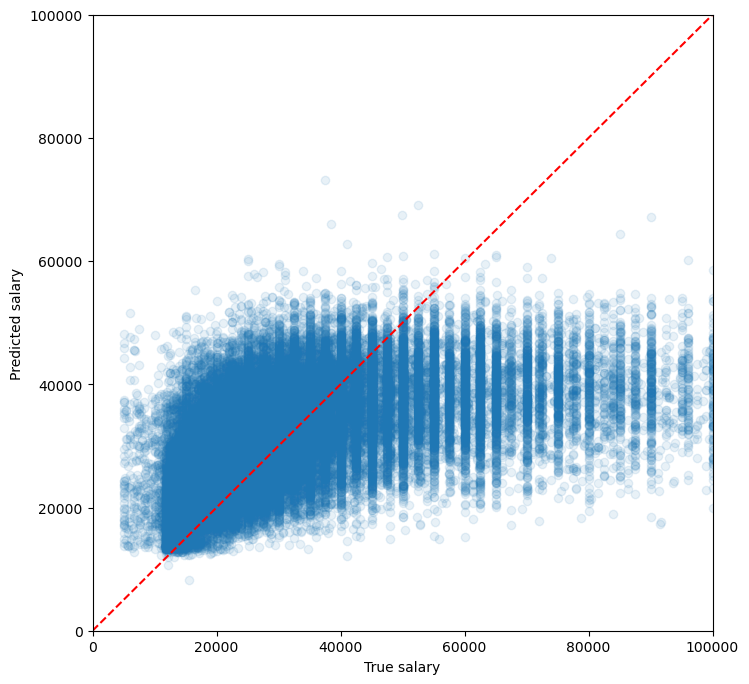

In [38]:
plt.figure(figsize=[8, 8])
plt.scatter(val_targets, val_preds, alpha=0.1)
plt.xlabel("True salary")
plt.ylabel("Predicted salary")
plt.plot([0, 100000], [0, 100000], color='red', linestyle='--')
plt.xlim([0, 100000])
plt.ylim([0, 100000])
plt.show()

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!